In [1]:
import utility_common as common
import utility_commonPlot as commonp
from fit_tcmodel import *

from timeit import default_timer as timer

# 1. Load Input-Label and Model

In [22]:
baseDir = common.getBaseDirectory()
shaping = True

if shaping:
    X = np.load(baseDir + "data/templates/shaping_signalRegion/X_.npy")
    X1 = np.load(baseDir + "data/templates/shaping_controlRegion/X_.npy")
else:
    X = np.load(baseDir + "data/templates/counting_signalRegion/X_.npy")
    X1 = np.load(baseDir + "data/templates/counting_controlRegion/X_.npy")

X  = tc.from_numpy(X ).type(tc.FloatTensor ).to(device)
X1 = tc.from_numpy(X1).type(tc.FloatTensor ).to(device)   
Y  = tc.sum(X ,1).to(device) + 0.1
Y1 = tc.sum(X1,1).to(device) + 0.1


# Model and optimizer
model     = TCPredictiveModel(True).to(device)
optimizer = tc.optim.LBFGS( model.parameters(),
                            lr=1, max_iter=50)

# 2. Training 

In [23]:
losses = []
# define backprop step
def closure():
    optimizer.zero_grad()
    y,regu,y1 = model.forward(X,X1)
    loss  = tc.sum( (y -Y )**2/(2*Y ) ) 
    loss += tc.sum( (y1-Y1)**2/(2*Y1) ) 
    loss += regu
    losses.append(loss)
    loss.backward(retain_graph=True) 
    return loss
# run optimization
start = timer()
optimizer.step(closure)
end = timer()
print('fitting time = {:6.4f} ms'.format( (end-start)*1000 ))

fitting time = 785.0991 ms


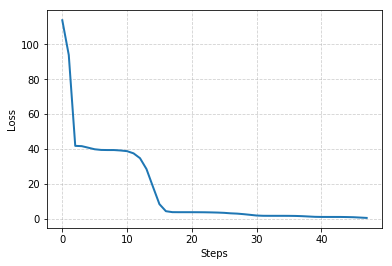

In [24]:
commonp.showLossHistory(losses[2:])
plt.savefig('../plots/fit/optimizaing',dpi=300)

# 3. Calculate Hessian of Loss

hessian time = 1028.3747 ms


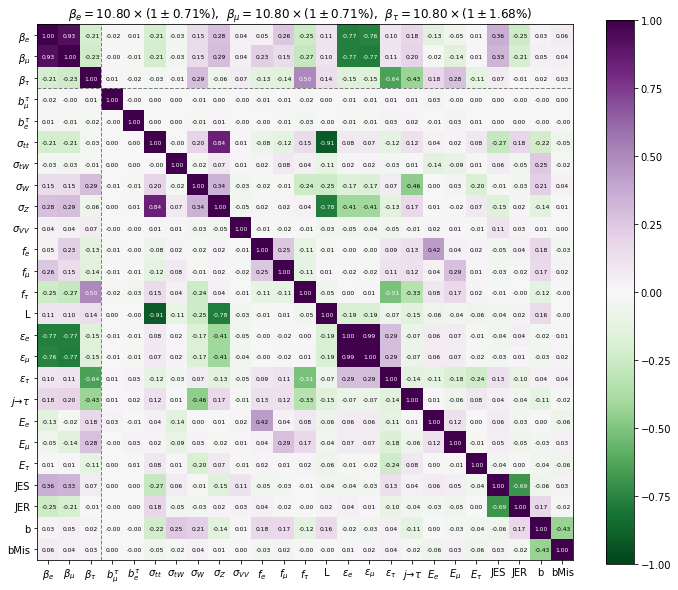

In [9]:
# forward prop X
y,regu,y1 = model.forward(X,X1)
# calculate loss and params
loss  = tc.sum( (y -Y )**2/(2*Y ) ) 
loss += tc.sum( (y1-Y1)**2/(2*Y1) ) 
loss += regu
# autograd loss w.r.t. params
start = timer()
hess = autograd2nd(loss, model)
end = timer()
print('hessian time = {:6.4f} ms'.format( (end-start)*1000 ))

hessinv = np.linalg.inv(hess)
sig = np.sqrt(hessinv.diagonal())
cor = hessinv/np.outer(sig, sig)

# show correlation and sigma
commonp.showParameterCovMat(cor,sig)

In [15]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name,param.data)
        
print(sig[0:3]/0.1080*100)
print(sig[3:])

layer_beta.params tensor([0.1081, 0.1081, 0.1070])
layer_btl.params tensor([-0.0044, -0.0545])
layer_xs.params tensor([-0.0390, -0.0835, -0.1094, -0.0155, -0.1214, -0.0211,  0.0368, -0.1789,
         0.0487])
layer_eff.params tensor([0.0360, 0.0346, 0.1529, 0.2012])
layer_itp.params tensor([ 0.0914,  0.0169,  0.0394, -0.0079, -0.0350, -0.0039,  0.0029])
[0.71203237 0.71134664 1.68314907]
[0.99894852 0.99732849 0.43279618 0.91626569 0.75460112 0.44105302
 0.98718658 0.36807524 0.1648939  0.17210772 0.79179395 0.64318466
 0.64194592 0.36162308 0.29194665 0.18322787 0.34073647 0.25933223
 0.12545804 0.22703744 0.02901351 0.63941672]
